# Calculcate Inter-annotator agreement for word tokenizers

In [1]:
import pandas as pd
import numpy as np
import os
import math
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import time
import itertools
from zimp.pos.tokenization.builder import SentenceTokenizerStrategy
from zimp.pos.sentence_count_analyzer import SentenceCountAnalyzer
from glob import glob
from sklearn.metrics import cohen_kappa_score, mean_absolute_error

plt.style.use('seaborn-whitegrid')

source_dir = '../../zimp_orchestrator/orch/resources'
files = {}

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
for ds_path in glob(source_dir + '/*'):
    if not os.path.isdir(ds_path):
        continue
    ds_name = os.path.basename(ds_path)
    files[ds_name] = [os.path.join(ds_path, 'train.csv'), os.path.join(ds_path, 'test.csv')]

In [3]:
def get_sentence_counts(paths, sca_builder, track_name):
    texts = pd.read_csv(paths[0]).text.append(pd.read_csv(paths[1]).text)
    df = pd.Series(sca_builder(texts).extract_batch_metrics(), name=track_name)
    return df

In [4]:
def plot_kappas(label_lst, dataset_name):
    kappas = np.ones((len(label_lst), len(label_lst)))
    for j, k in list(itertools.combinations(range(len(label_lst)), 2)):
        kappas[j,k] = cohen_kappa_score(label_lst[j], label_lst[k])
        kappas[k,j] = kappas[j,k]
    
    plt.figure(figsize=(10,8))
    sns.heatmap(
        kappas, 
        annot=True, linewidths=5,
        vmin=0, vmax=1,
        xticklabels=[s.name for s in label_lst],
        yticklabels=[s.name for s in label_lst]
    )
    plt.title(f'Cohen Kappa for Sentence Counts ({dataset_name})')
    plt.savefig(f'sentence_compare/kappa_{dataset_name}.pdf')
    plt.show()

In [5]:
def plot_pearson_cor(label_lst, dataset_name):
    kappas = np.ones((len(label_lst), len(label_lst)))
    for j, k in list(itertools.combinations(range(len(label_lst)), 2)):
        kappas[j,k] = label_lst[j].corr(label_lst[k])
        kappas[k,j] = kappas[j,k]
    
    plt.figure(figsize=(10,8))
    sns.heatmap(
        kappas, 
        annot=True, linewidths=5,
        vmin=-1, vmax=1,
        xticklabels=[s.name for s in label_lst],
        yticklabels=[s.name for s in label_lst]
    )
    plt.title(f'Pearson Correlation Coefficient for Sentence Counts ({dataset_name})')
    plt.savefig(f'sentence_compare/pearson_{dataset_name}.pdf')
    plt.show()

In [6]:
def plot_mae(label_lst, dataset_name):
    kappas = np.zeros((len(label_lst), len(label_lst)))
    for j, k in list(itertools.combinations(range(len(label_lst)), 2)):
        kappas[j,k] = mean_absolute_error(label_lst[j], label_lst[k])
        kappas[k,j] = kappas[j,k]
    
    plt.figure(figsize=(10,8))
    sns.heatmap(
        kappas, 
        annot=True, linewidths=5,
        vmin=0, vmax=kappas.max(),
        xticklabels=[s.name for s in label_lst],
        yticklabels=[s.name for s in label_lst]
    )
    plt.title(f'MAE for Sentence Counts ({dataset_name})')
    plt.savefig(f'sentence_compare/mae_{dataset_name}.pdf')
    plt.show()

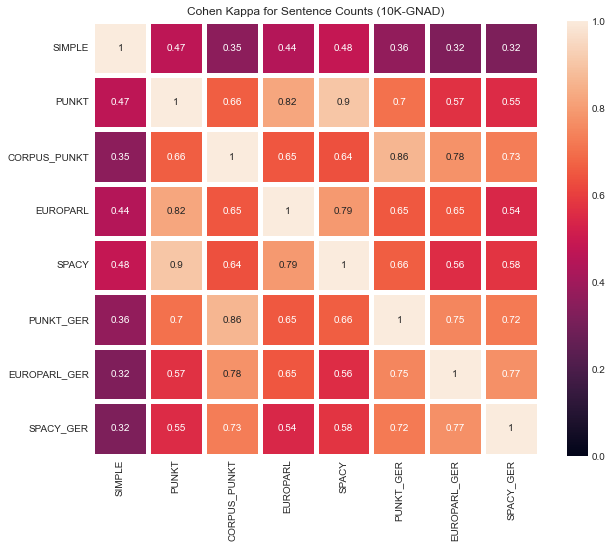

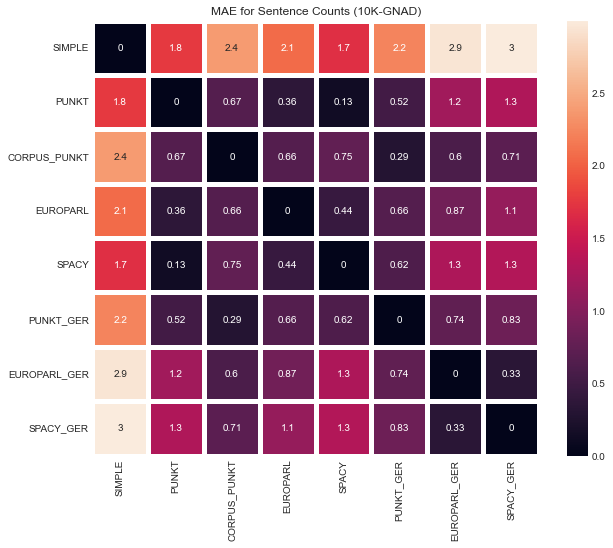

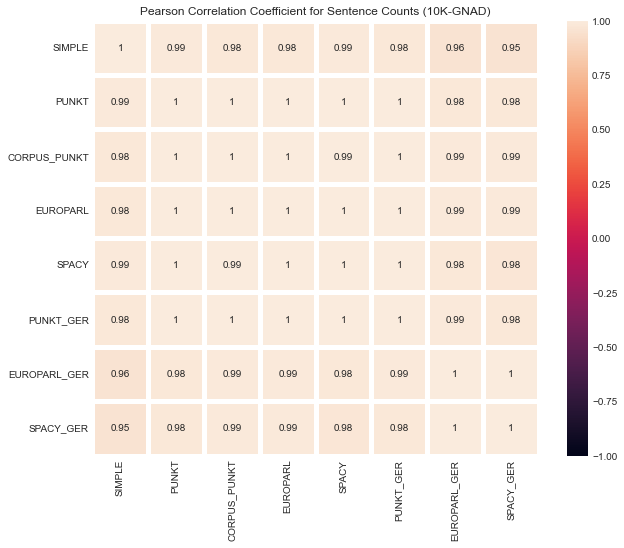

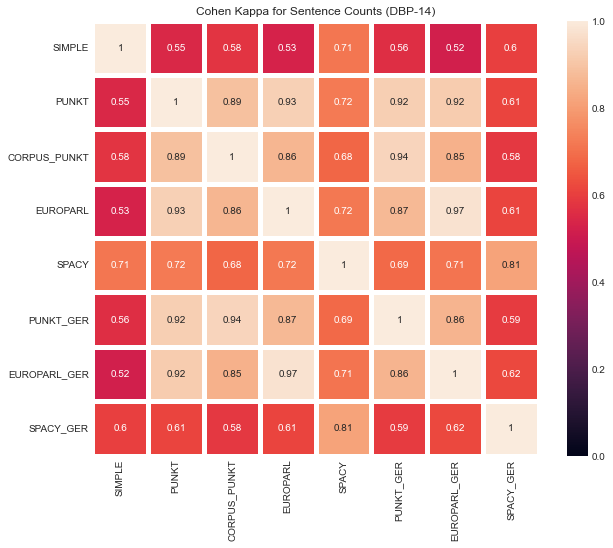

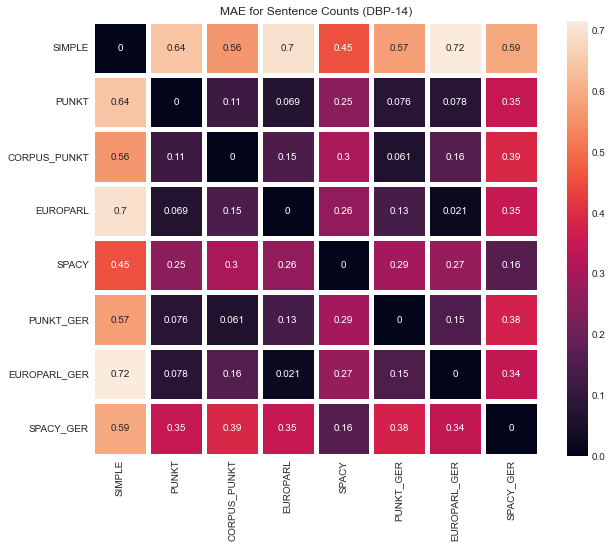

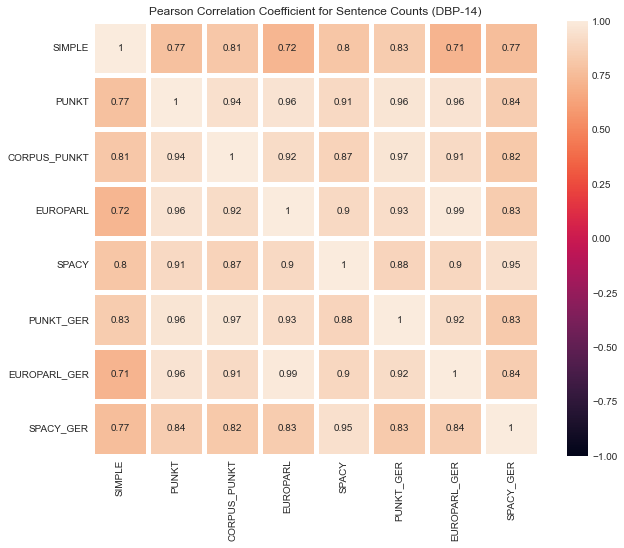

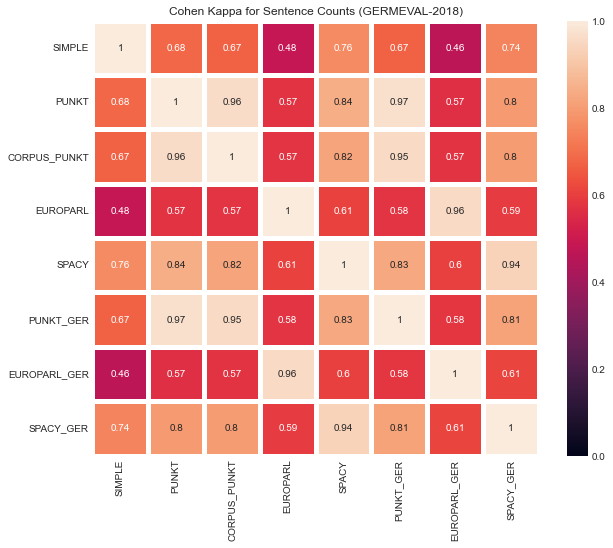

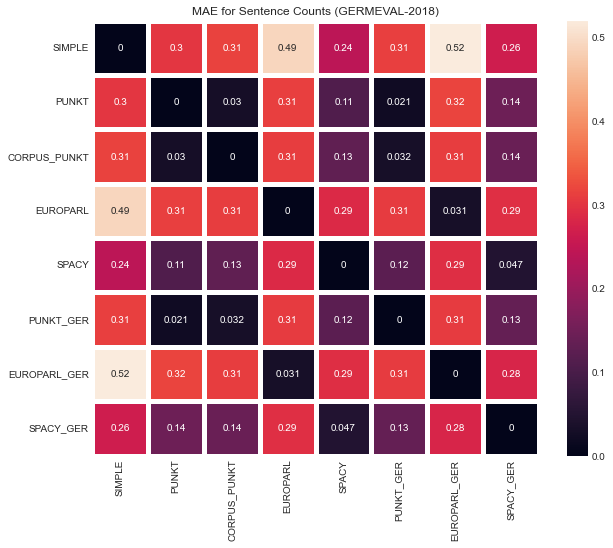

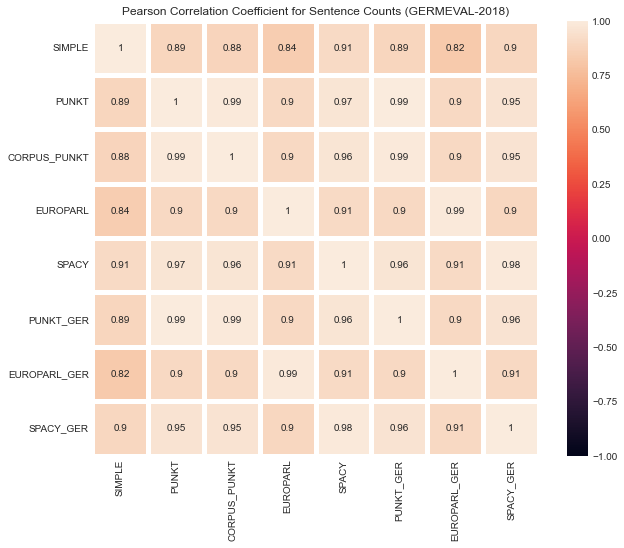

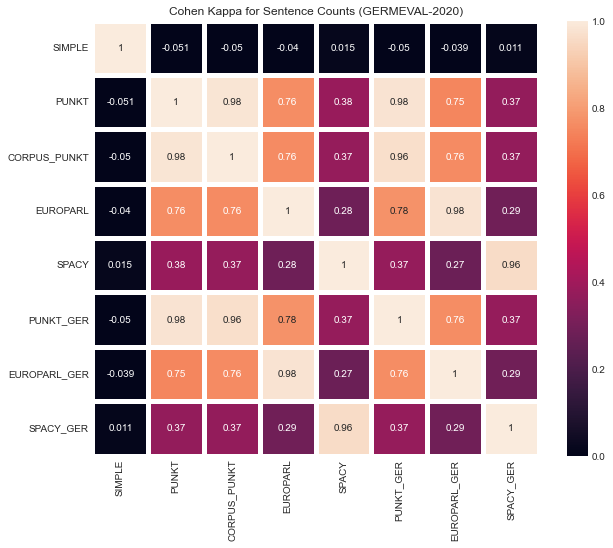

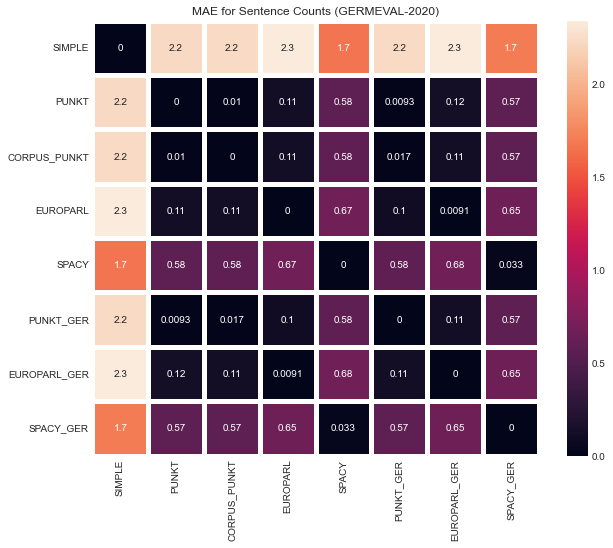

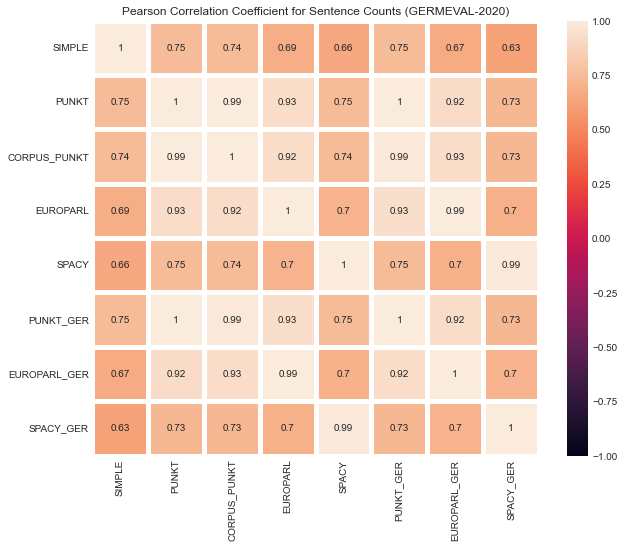

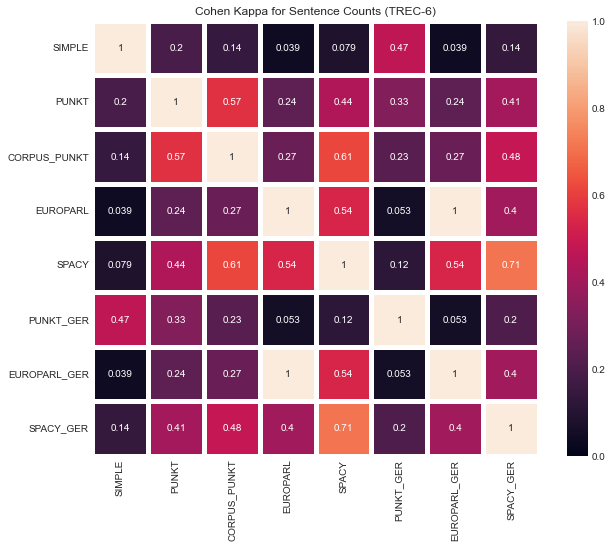

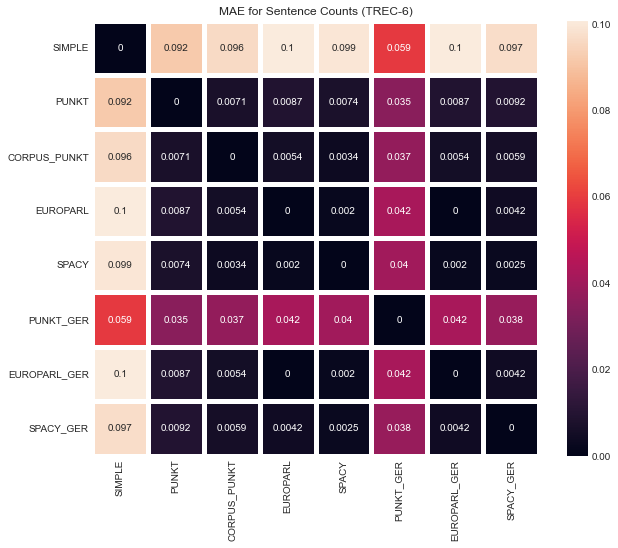

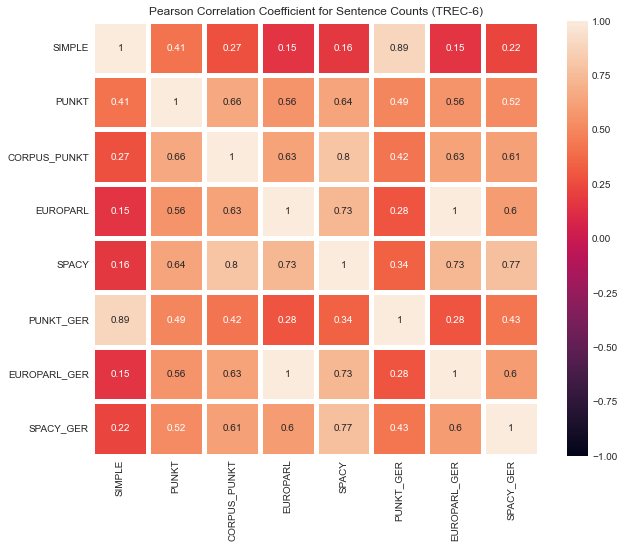

MemoryError: 

In [7]:
for dataset in files.keys():
    s_lst = []
    for strategy in SentenceTokenizerStrategy:
        s_lst.append(get_sentence_counts(files[dataset], lambda texts: SentenceCountAnalyzer(texts, strategy=strategy), strategy.name))
    s_lst.append(get_sentence_counts(files[dataset], lambda texts: SentenceCountAnalyzer(texts, strategy=SentenceTokenizerStrategy.PUNKT, language='german'), 'PUNKT_GER'))
    s_lst.append(get_sentence_counts(files[dataset], lambda texts: SentenceCountAnalyzer(texts, strategy=SentenceTokenizerStrategy.EUROPARL, language='german'), 'EUROPARL_GER'))
    s_lst.append(get_sentence_counts(files[dataset], lambda texts: SentenceCountAnalyzer(texts, strategy=SentenceTokenizerStrategy.SPACY, language='german'), 'SPACY_GER'))
    plot_kappas(s_lst, dataset)
    plot_mae(s_lst, dataset)
    plot_pearson_cor(s_lst, dataset)